In [57]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import matplotlib.pyplot as plt

In [58]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [59]:
from stocktrends import indicators

In [60]:
data={} # Dictionary to contain pandas dataframe for all the stocks. This is to avoid creating variable for each stock 
        # to store data
finalData={} # This should contain our final output and that is Renko OHLC data
n=7 # Period for ATR
renkoData={} # It contains information on the lastest bar of renko data for the number of stocks we are working on

In [61]:
def ATR(df,n): #df is the DataFrame, n is the period 7,14 ,etc
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR']=np.nan
    df.loc[df.index[n-1],'ATR']=df['TR'][:n-1].mean() #.ix is deprecated from pandas version- 0.19
    for i in range(n,len(df)):
        df['ATR'][i]=(df['ATR'][i-1]*(n-1)+ df['TR'][i])/n
    return

In [62]:
StockList=['AUROPHARMA', 'BAJFINANCE']

In [63]:
start='2019-1-1'
for stock in StockList:
    data[stock]=pdr.get_data_yahoo(stock+'.NS', start)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [64]:
for stock in data:
    if data[stock].empty:
        print(stock)

In [65]:
for stock in data:
    print (stock, data[stock].head())

AUROPHARMA              Open        High         Low       Close   Adj Close   Volume
Date                                                                      
2019-01-01  734.0  737.500000  729.599976  733.150024  727.385925  1340165
2019-01-02  729.0  732.400024  719.000000  724.349976  718.655029  1845752
2019-01-03  721.0  723.400024  710.549988  715.900024  710.271545  1357059
2019-01-04  714.0  728.000000  708.250000  725.849976  720.143250  1340101
2019-01-07  726.0  731.000000  719.599976  724.750000  719.051880  1413246
BAJFINANCE                    Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-01-01  2645.000000  2664.000000  2612.100098  2656.850098  2646.119385   
2019-01-02  2635.100098  2662.000000  2601.899902  2614.050049  2603.492188   
2019-01-03  2612.000000  2648.000000  2575.300049  2586.199951  2575.754395   
2019-01-04  2601.000000  2611.899902  2563.649902  2576.05

In [66]:
for stock in data:
    data[stock].drop(data[stock][data[stock].Volume == 0].index, inplace=True) # Data Cleaning
    ATR(data[stock],n)
    data[stock]=data[stock][['Open','High','Low','Close','ATR']] # Removing unwanted columns

In [67]:
for stock in data:
    renkoData[stock]={'BrickSize':0.0, 'Open':0.0,'Close':0.0,'Color':''}

In [68]:
for stock in data:
    #renkoData[stock]['BrickSize']=round(data[stock]['ATR'][-1],2) #This can be set manually as well!
    renkoData['AUROPHARMA']['BrickSize'] = 2
    renkoData['BAJFINANCE']['BrickSize'] = 5
    renkoData[stock]['Open']=renkoData[stock]['BrickSize']+renkoData[stock]['Close'] # This can be done the otherway round
                                                                                    # as well.'Close' = 'BrickSize' - 'Open' 
    renkoData[stock]['Color']='red'    # Should you choose to do the other way round, please change the color to 'green'

In [69]:
renkoData['AUROPHARMA']

{'BrickSize': 2, 'Open': 2.0, 'Close': 0.0, 'Color': 'red'}

In [70]:
renkoData['BAJFINANCE']

{'BrickSize': 5, 'Open': 5.0, 'Close': 0.0, 'Color': 'red'}

In [71]:
for stock in data:
    finalData[stock]=pd.DataFrame()
    finalData[stock].index.name='Date'
    finalData[stock]['ReOpen']=0.0
    finalData[stock]['ReHigh']=0.0
    finalData[stock]['ReLow']=0.0
    finalData[stock]['ReClose']=0.0
    finalData[stock]['Color']=''

In [72]:
for stock in data: # This loops thorugh all the stocks in the data dictionary
    for index,row in data[stock].iterrows(): # One may choose to use Pure python instead of Iterrows to loop though each n 
                                         # every row to improve performace if datasets are large.
        if renkoData[stock]['Open']> renkoData[stock]['Close']: 
            while row['Close']> renkoData[stock]['Open']+renkoData[stock]['BrickSize']:
                renkoData[stock]['Open']+=renkoData[stock]['BrickSize']
                renkoData[stock]['Close']+=renkoData[stock]['BrickSize']
                finalData[stock].loc[index]=row
                finalData[stock]['ReOpen'].loc[index]= renkoData[stock]['Close']         
                finalData[stock]['ReHigh'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['ReLow'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['ReClose'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['Color'].loc[index]='green'

            while row['Close'] < renkoData[stock]['Close']-renkoData[stock]['BrickSize']:
                renkoData[stock]['Open']-=renkoData[stock]['BrickSize']
                renkoData[stock]['Close']-=renkoData[stock]['BrickSize']
                finalData[stock].loc[index]=row
                finalData[stock]['ReOpen'].loc[index]= renkoData[stock]['Open']         
                finalData[stock]['ReHigh'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['ReLow'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['ReClose'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['Color'].loc[index]='red'
                
        else:
            while row['Close']< renkoData[stock]['Open']-renkoData[stock]['BrickSize']:
                renkoData[stock]['Open']-=renkoData[stock]['BrickSize']
                renkoData[stock]['Close']-=renkoData[stock]['BrickSize']
                finalData[stock].loc[index]=row
                finalData[stock]['ReOpen'].loc[index]= renkoData[stock]['Close']         
                finalData[stock]['ReHigh'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['ReLow'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['ReClose'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['Color'].loc[index]='red'
                
            while row['Close'] > renkoData[stock]['Close']+renkoData[stock]['BrickSize']:
                renkoData[stock]['Open']+=renkoData[stock]['BrickSize']
                renkoData[stock]['Close']+=renkoData[stock]['BrickSize']
                finalData[stock].loc[index]=row
                finalData[stock]['ReOpen'].loc[index]= renkoData[stock]['Open']         
                finalData[stock]['ReHigh'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['ReLow'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['ReClose'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['Color'].loc[index]='green'

In [74]:
finalData['AUROPHARMA'].head(5)

,ReOpen,ReHigh,ReLow,ReClose,Color
Date,,,,,
2019-01-01,730.0,732.0,730.0,732.0,green
2019-01-02,728.0,728.0,726.0,726.0,red
2019-01-03,718.0,718.0,716.0,716.0,red
2019-01-04,722.0,724.0,722.0,724.0,green
2019-01-08,744.0,746.0,744.0,746.0,green


In [75]:
finalData['BAJFINANCE'].head(5)


,ReOpen,ReHigh,ReLow,ReClose,Color
Date,,,,,
2019-01-01,2650.0,2655.0,2650.0,2655.0,green
2019-01-02,2620.0,2620.0,2615.0,2615.0,red
2019-01-03,2595.0,2595.0,2590.0,2590.0,red
2019-01-04,2585.0,2585.0,2580.0,2580.0,red
2019-01-07,2560.0,2560.0,2555.0,2555.0,red


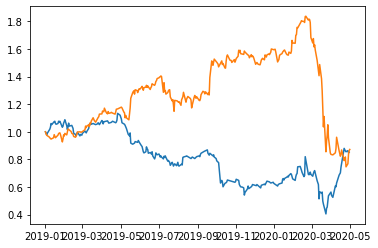

In [95]:
plt.plot(finalData['AUROPHARMA']['ReClose']/finalData['AUROPHARMA']['ReClose'][0])
plt.plot(finalData['BAJFINANCE']['ReClose']/finalData['BAJFINANCE']['ReClose'][0])

In [77]:
data['diff'] =((data['AUROPHARMA']['Close']/finalData['AUROPHARMA']['ReClose'][0])-(data['BAJFINANCE']['Close']/finalData['BAJFINANCE']['ReClose'][0]))*100

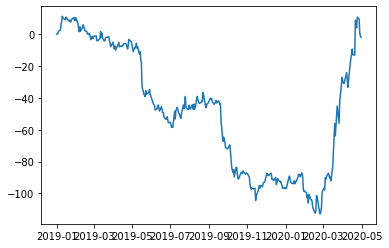

In [78]:
plt.plot(data['diff'])

In [79]:
v = 0
l = [v for i in range(len(data['diff']))]
for i in range(len(data['diff'])):
    for j in range(i):
        l[i] += data['diff'][j]

In [80]:
data['diff_c'] = l

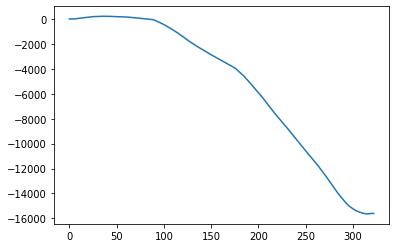

In [81]:
plt.plot(data['diff_c'])

In [82]:
df_a = pd.DataFrame.from_dict(data['AUROPHARMA'])
df_a = df_a[['Open','High','Low','Close']]
#df_a = df_a.columns.drop('Date')
df_a = df_a.reset_index()
# date_a = df_a.index
# date_a = pd.to_datetime(date_a)
# df_a = df_a.reset_index()
# df_a['date'] = date_a
df_a.columns = [i.lower() for i in df_a.columns]

In [83]:
df_a.columns

Index(['date', 'open', 'high', 'low', 'close'], dtype='object')

In [84]:
df_b = pd.DataFrame.from_dict(data['BAJFINANCE'])
df_b = df_b.reset_index()
# date_b = df_b.index
# date_b = pd.to_datetime(date_b)
# df_b = df_b.reset_index()
# df_b['date'] = date_b
df_b.columns = [i.lower() for i in df_b.columns]

In [85]:
df_b.columns

Index(['date', 'open', 'high', 'low', 'close', 'atr'], dtype='object')

In [86]:
lb_a = indicators.LineBreak(df_a)

print('\n\nAuroPharma Line break chart')
lb_a.line_number = 1
data_lb_a = lb_a.get_ohlc_data()
print(data_lb_a.tail(rows))



AuroPharma Line break chart
     index       date        open        high         low       close  uptrend
216      0 2020-04-09  445.700012  460.200012  445.700012  460.200012     True
217      0 2020-04-13  460.200012  503.200012  460.200012  503.200012     True
218      0 2020-04-15  503.200012  514.700012  503.200012  514.700012     True
219      0 2020-04-16  514.700012  544.650024  514.700012  544.650024     True
220      0 2020-04-21  544.650024  644.400024  544.650024  644.400024     True


In [87]:
lb_b = indicators.LineBreak(df_b)
rows = 5
print('\n\nBAJAJ FINANCE Line break chart')
lb_b.line_number = 1
data_lb_b = lb_b.get_ohlc_data()
print(data_lb_b.tail(rows))



BAJAJ FINANCE Line break chart
     index       date         open         high          low        close  \
202      0 2020-04-21  2308.149902  2308.149902  2099.750000  2099.750000   
203      0 2020-04-24  2099.750000  2099.750000  1976.250000  1976.250000   
204      0 2020-04-28  2099.750000  2228.100098  2099.750000  2228.100098   
205      0 2020-04-29  2228.100098  2296.449951  2228.100098  2296.449951   
206      0 2020-04-30  2296.449951  2318.100098  2296.449951  2318.100098   

     uptrend  
202    False  
203    False  
204     True  
205     True  
206     True  


In [88]:
lb_chart_a = data_lb_a[['close']]
date_time_a = data_lb_a['date']
date_time_a = pd.to_datetime(date_time_a)
lb_chart_a = lb_chart_a.set_index(date_time_a)

lb_chart_b = data_lb_b[['close']]
date_time_b = data_lb_b['date']
date_time_b = pd.to_datetime(date_time_b)
lb_chart_b = lb_chart_b.set_index(date_time_b)

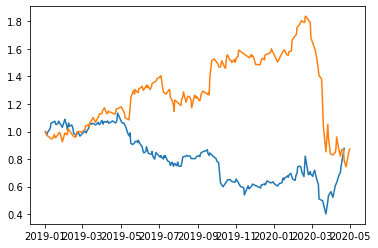

In [89]:
plt.plot(lb_chart_a/lb_chart_a['close'][0])
plt.plot(lb_chart_b/lb_chart_b['close'][0])


In [90]:
df1 = pd.DataFrame.from_dict(data['AUROPHARMA'])

In [91]:
df2 = pd.DataFrame.from_dict(data['BAJFINANCE'])

In [92]:
df1['ratio'] = (df1['Close']/df1['Close'][0])/(df2['Close']/df2['Close'][0])
df2['ratio'] = (df2['Close']/df2['Close'][0])/(df1['Close']/df1['Close'][0])

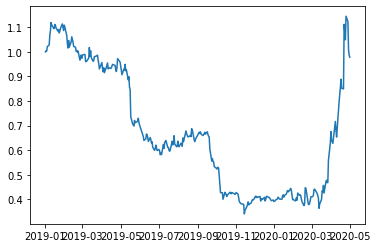

In [93]:
plt.plot(df1['ratio'])

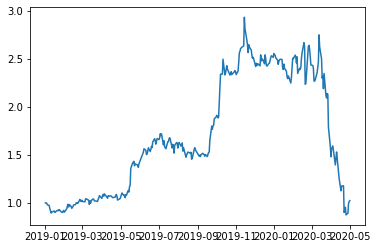

In [94]:
plt.plot(df2['ratio'])